In [1]:
import sys
sys.path.append('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders')


from get_data import get_data, get_data_train, get_data_val
import torch
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datasets import InMemDataLoader
import torch.nn.functional as F
import torch
import nibabel as nib     # Read / write access to some common neuroimaging file formats
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
from scipy import interpolate
import ot

import jmp_solver1.surrogates
import matplotlib
matplotlib.rcdefaults() 

In [2]:
device

device(type='cpu')

In [3]:
# Get RK coefficients for these images and also the images

In [4]:
#before executing this cell you need to have preexisting trained coefficients for what ever degree you want
#trainImages = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/FMNIST_RK_coeffs/trainImages.pt',map_location=torch.device('cpu'))
#rainCoeffs = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/FMNIST_RK_coeffs/coeffs_saved/LSTSQ_traincoeffs_FMNIST_dq'+str(deg_quad)+'.pt',map_location=torch.device('cpu'))




In [5]:
Analys_size = 200

In [6]:
from models_un import AE_un
from models import AE
from activations import Sin

In [7]:
# load trained rAE and bAE
latent_dims = [20, 18, 16, 14, 12, 10, 8, 6, 4, 2]
all_hyb_base_models = []

all_test_coeffs = []
all_X_p = []
for lat_dim in latent_dims:
    deg_quad = 20
    u_ob = jmp_solver1.surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
    x = np.linspace(-1,1,32)
    X_p = u_ob.data_axes([x,x]).T

    testImages = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/FMNIST_RK_coeffs/testImages.pt',map_location=torch.device('cpu'))
    testCoeffs = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/FMNIST_RK_coeffs/coeffs_saved/LSTSQ_testcoeffs_FMNIST_dq'+str(deg_quad)+'.pt',map_location=torch.device('cpu'))

    testImages = testImages[:Analys_size]
    testCoeffs = testCoeffs[:Analys_size]

    path_hyb = '/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/FMNIST_RK_space/output/MRT_full/test_run_saving/'
    path_unhyb = '/home/ramana44/FashionMNIST5LayersTrials/output/MRT_full/test_run_saving/'

    #specify hyperparameters
    reg_nodes_sampling = 'legendre'
    alpha = 0.5
    frac = 0.4
    hidden_size = 100
    deg_poly = 21
    deg_poly_forRK = 21
    latent_dim = lat_dim
    lr = 0.0001
    no_layers = 3
    no_epochs= 100
    name_hyb = '_'+reg_nodes_sampling+'_'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly_forRK)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)#+'_'+str(no_epochs)
    name_unhyb = '_'+reg_nodes_sampling+'__'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)#+'_'+str(no_epochs)

    inp_dim_hyb = (deg_quad+1)*(deg_quad+1)

    inp_dim_unhyb = [1,32,32]

    RK_model_reg = AE(inp_dim_hyb, hidden_size, latent_dim, no_layers, Sin()).to(device)
    #RK_model_base = AE(inp_dim_hyb, hidden_size, latent_dim, no_layers, Sin()).to(device)

    RK_model_reg.load_state_dict(torch.load(path_hyb+'model_regLSTQS'+str(deg_quad)+''+name_hyb, map_location=torch.device('cpu')))
    #RK_model_base.load_state_dict(torch.load(path_hyb+'model_baseLSTQS'+str(deg_quad)+''+name_hyb, map_location=torch.device('cpu')))

    all_hyb_base_models.append(RK_model_reg)
    all_test_coeffs.append(testCoeffs)
    all_X_p.append(X_p)


In [8]:
all_test_coeffs[0].shape

torch.Size([200, 441])

In [9]:
all_hyb_base_models[3]

AE(
  (encoder): Encoder(
    (activation): Sin()
    (lin_layers): ModuleList(
      (0): Linear(in_features=441, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Linear(in_features=100, out_features=14, bias=True)
    )
  )
  (decoder): Decoder(
    (activation): Sin()
    (lin_layers): ModuleList(
      (0): Linear(in_features=14, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Linear(in_features=100, out_features=441, bias=True)
    )
  )
)

In [10]:
#rec_rAE_train = RK_model_reg(trainCoeffs.float()).view(trainCoeffs.shape)
#rec_bAE_train = RK_model_base(trainCoeffs.float()).view(trainCoeffs.shape)

#rec_rAE_test = RK_model_reg(testCoeffs.float()).view(testCoeffs.shape)
#rec_bAE_test = RK_model_base(testCoeffs.float()).view(testCoeffs.shape)

all_rec_bAE_test = []
for i in range(len(latent_dims)):
    rec_bAE_test = all_hyb_base_models[i].encoder(all_test_coeffs[i].float())#.view(all_test_coeffs[i].shape)
    rec_bAE_test = torch.tensor(rec_bAE_test, requires_grad=False)
    all_rec_bAE_test.append(rec_bAE_test)

/tmp/ipykernel_65281/2758191667.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_bAE_test = torch.tensor(rec_bAE_test, requires_grad=False)


In [11]:
all_rec_bAE_test[4].shape

torch.Size([200, 12])

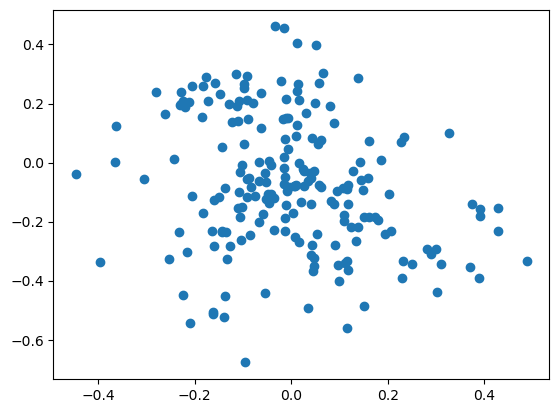

In [12]:
plt.scatter(all_rec_bAE_test[4][:,0], all_rec_bAE_test[4][:,1])

In [13]:
# reconstruction loss after training the model completely
#loss_tre = torch.mean(((rec_rAE_train - trainCoeffs)**2)*0.5)
#loss_tre

In [14]:
len(all_rec_bAE_test)

10

In [15]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [16]:
dist_matrix_Lat_10 = _compute_distance_matrix(all_rec_bAE_test[4], p=2)

In [17]:
all_rec_bAE_test[0].shape

torch.Size([200, 20])

In [18]:
dist_matrix_Lat_10.shape

torch.Size([200, 200])

In [ ]:

#from ripser import ripser
import ripser
import persim
from persim import plot_diagrams


import time


: 

In [20]:
testImages.shape

torch.Size([200, 1, 32, 32])

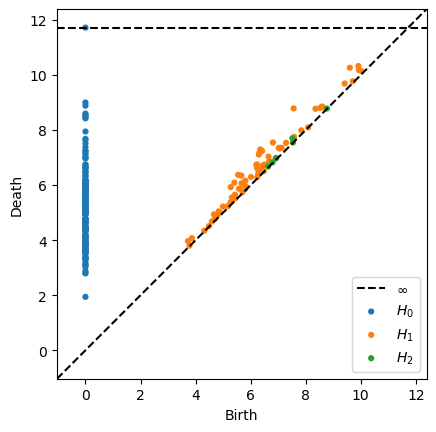

In [21]:
dist_matrix_Lat_ori = _compute_distance_matrix(testImages, p=2)

diagrams_ori = ripser.ripser(dist_matrix_Lat_ori.cpu().detach().numpy(), distance_matrix=True, maxdim=2)['dgms']
plot_diagrams(diagrams_ori, show=True)

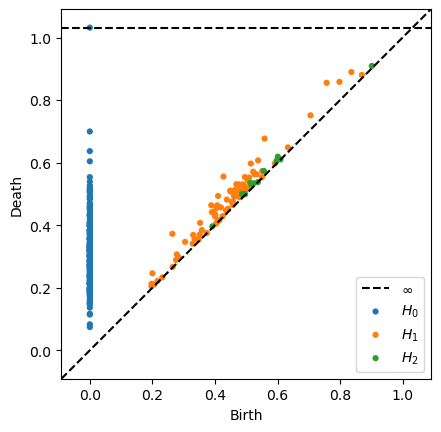

In [22]:
dist_matrix_Lat_10 = _compute_distance_matrix(all_rec_bAE_test[0], p=2)

diagrams10 = ripser.ripser(dist_matrix_Lat_10.cpu().detach().numpy(), distance_matrix=True, maxdim=2)['dgms']
plot_diagrams(diagrams10, show=True)

In [23]:
diagrams10[1]

array([[0.86986548, 0.88042951],
       [0.83609664, 0.88960356],
       [0.79811782, 0.8581242 ],
       [0.75703251, 0.8552286 ],
       [0.7053383 , 0.75120485],
       [0.63329732, 0.64863694],
       [0.59169453, 0.59694922],
       [0.55859631, 0.67690164],
       [0.55110723, 0.57294077],
       [0.5503056 , 0.5532847 ],
       [0.53779042, 0.60707504],
       [0.53358108, 0.56253898],
       [0.52653509, 0.56286609],
       [0.52231234, 0.57093084],
       [0.51474577, 0.59694922],
       [0.50945139, 0.55224794],
       [0.50389802, 0.54485428],
       [0.50386953, 0.5163461 ],
       [0.50251281, 0.51675695],
       [0.49579033, 0.51178986],
       [0.49571803, 0.55398041],
       [0.49490687, 0.52545625],
       [0.4884707 , 0.53014964],
       [0.48739091, 0.52884924],
       [0.48674423, 0.50910217],
       [0.47958297, 0.52532434],
       [0.47942871, 0.48909593],
       [0.47836483, 0.53004616],
       [0.47353622, 0.52884924],
       [0.47133005, 0.51056564],
       [0.

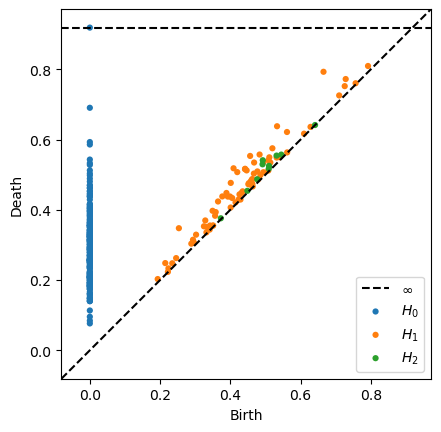

In [24]:
dist_matrix_Lat_8 = _compute_distance_matrix(all_rec_bAE_test[1], p=2)

diagrams8 = ripser.ripser(dist_matrix_Lat_8.cpu().detach().numpy(), distance_matrix=True, maxdim=2)['dgms']
plot_diagrams(diagrams8, show=True)

In [25]:
diagrams8[2]

array([[0.64139879, 0.64154363],
       [0.54521215, 0.5572952 ],
       [0.53171647, 0.55448413],
       [0.51027131, 0.52516454],
       [0.50960189, 0.51729774],
       [0.49250504, 0.54118347],
       [0.49180394, 0.52959126],
       [0.47671252, 0.48710576],
       [0.44867933, 0.45418271],
       [0.37301987, 0.37593469]])

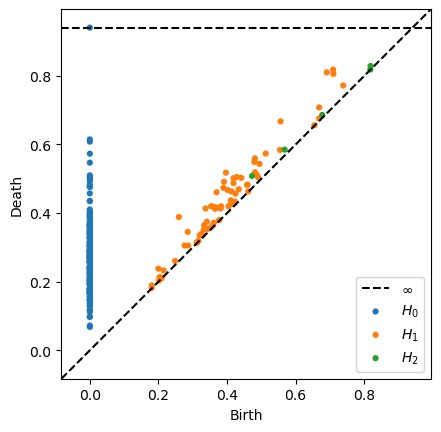

In [26]:
dist_matrix_Lat_6 = _compute_distance_matrix(all_rec_bAE_test[2], p=2)

diagrams6 = ripser.ripser(dist_matrix_Lat_6.cpu().detach().numpy(), distance_matrix=True, maxdim=2)['dgms']
plot_diagrams(diagrams6, show=True)

In [27]:
diagrams6[2]

array([[0.81834012, 0.82886207],
       [0.81787974, 0.81845891],
       [0.67753255, 0.68615663],
       [0.56799763, 0.58503544],
       [0.47265613, 0.50823051]])

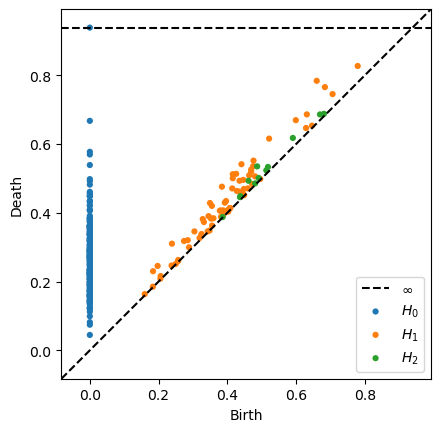

In [28]:
dist_matrix_Lat_4 = _compute_distance_matrix(all_rec_bAE_test[3], p=2)

diagrams4 = ripser.ripser(dist_matrix_Lat_4.cpu().detach().numpy(), distance_matrix=True, maxdim=2)['dgms']
plot_diagrams(diagrams4, show=True)

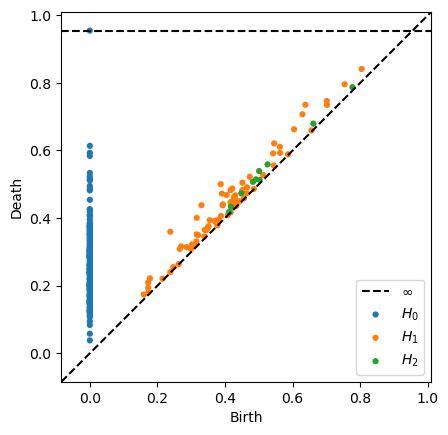

In [29]:
dist_matrix_Lat_2 = _compute_distance_matrix(all_rec_bAE_test[4], p=2)

diagrams2 = ripser.ripser(dist_matrix_Lat_2.cpu().detach().numpy(), distance_matrix=True, maxdim=2)['dgms']
plot_diagrams(diagrams2, show=True)

In [30]:
# L2 differecences of Persistent Homology Signatures in Latent Spaces like Lat10 - Lat8, lat8 - Lat6, lat6 - Lat4, lat4 - Lat2 

all_mse = []
for i in range(len(latent_dims)):
    dist_matrix_Lat = _compute_distance_matrix(all_rec_bAE_test[i], p=2)
    diagrams = ripser.ripser(dist_matrix_Lat.cpu().detach().numpy(), distance_matrix=True, maxdim=2)['dgms']
    #plot_diagrams(diagrams10, show=True)
    if(not i==0):

        mse = np.mean(np.sqrt((diagrams[0][:-1] - pre_diag[0][:-1])**2))
        all_mse.append(mse)
    pre_diag = diagrams


In [31]:
# L2 distances of Persistent homology signatures from original point cloud of images

all_mse = []
for i in range(len(latent_dims)):
    dist_matrix_Lat = _compute_distance_matrix(all_rec_bAE_test[i], p=2)
    diagrams = ripser.ripser(dist_matrix_Lat.cpu().detach().numpy(), distance_matrix=True, maxdim=2)['dgms']
    mse = np.mean(np.sqrt((diagrams[0][:-1] - diagrams_ori[0][:-1])**2))
    all_mse.append(mse)
    pre_diag = diagrams


In [32]:
all_mse

[2.43496918788732,
 2.4425296469324795,
 2.4517171143848993,
 2.4549563833741685,
 2.4586738163708293,
 2.464026326332335,
 2.4785018450107854,
 2.4989603315831053,
 2.5347872076312727,
 2.5715676195715935]

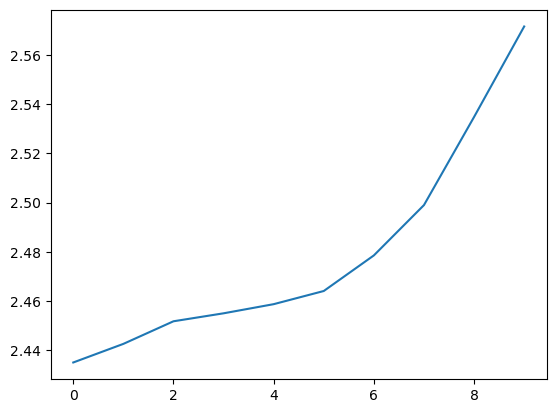

In [33]:
plt.plot(all_mse)

In [34]:
mse1 = np.mean(np.sqrt((diagrams10[0][:-1] - diagrams8[0][:-1])**2))
mse1

0.007600661217417549

In [35]:
mse2 = np.mean(np.sqrt((diagrams8[0][:-1] - diagrams6[0][:-1])**2))
mse2

0.009361840166788005

In [36]:
mse3 = np.mean(np.sqrt((diagrams6[0][:-1] - diagrams4[0][:-1])**2))
mse3

0.003742862043518517

In [37]:
mse4 = np.mean(np.sqrt((diagrams4[0][:-1] - diagrams2[0][:-1])**2))
mse4

0.0051720752544588775